# 1. Installing Dependencies RR1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tqdm
!pip install stopwords
!pip install nltk 
!pip install tweet-preprocessor

!pip install ipython-autotime
%load_ext autotime

!pip install transformers
!pip3 install torch

from IPython.display import clear_output
clear_output(wait=False)

time: 14.3 s (started: 2022-12-15 00:38:14 +00:00)


In [ ]:
# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 15 00:38:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Memory info
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
time: 2.79 ms (started: 2022-12-15 00:38:29 +00:00)


In [ ]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

# RoBERTa Scores Calculated
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

from google.colab import drive
drive.mount('/content/drive')

# specify GPU
device = torch.device("cuda")

clear_output(wait=False)

time: 27 s (started: 2022-12-15 00:38:29 +00:00)


# 2. Data Preparation on IMDB data

## *i) Import IMDB Dataset*

In [ ]:
# Data Import and loading in Dataframe
path = r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/IMDB_Train.csv'
df= pd.read_csv(path)

time: 1.5 s (started: 2022-12-12 22:30:35 +00:00)


In [ ]:
# Data Exploration - EDA
df.head(2)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0


time: 15.8 ms (started: 2022-12-12 22:30:36 +00:00)


In [ ]:
# Dataset Dimensions
print('Shape: ', df.shape)
print('Columns: ', df.columns)

Shape:  (40000, 2)
Columns:  Index(['text', 'label'], dtype='object')
time: 889 µs (started: 2022-12-12 22:30:36 +00:00)


In [ ]:
df.label.value_counts(normalize=True)

0    0.500475
1    0.499525
Name: label, dtype: float64

time: 6.56 ms (started: 2022-12-12 22:30:36 +00:00)


## *ii) Data Cleaning and Preprocessing*

In [ ]:
# Sample text
df.text[1]

"When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The actual drawings isnt that bad, 

time: 2.76 ms (started: 2022-12-12 22:30:46 +00:00)


In [ ]:
len(df.text[1])

1811

time: 3.59 ms (started: 2022-12-12 22:30:48 +00:00)


In [ ]:
df.isna().sum()

text     0
label    0
dtype: int64

time: 10.6 ms (started: 2022-12-12 22:31:15 +00:00)


In [ ]:
pd.set_option('display.max_colwidth', None)
# df.head()

time: 466 µs (started: 2022-12-12 22:30:53 +00:00)


In [ ]:
# Remove digits and making text lowercase for simplicity
df['text'] = df['text'].str.replace('\d+', '')
df['text'] = df['text'].str.lower()
# Removing Punctuations
df['text'] = df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)
df['tokens'] = df['text'].apply(lambda x: tk.tokenize(x))
# df.head(1)

<ipython-input-13-52aee6162245>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('\d+', '')


time: 49.5 s (started: 2022-12-12 22:32:28 +00:00)


In [ ]:
# A custom function defined in order to fine-tune the cleaning of the shorthands used in input text.  
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
# print(remove_noise(df['tokens'][1000]))   # tw1 has tokens and pos_tokens features

# Applying above function 
df['tokens'] = df['tokens'].apply(lambda x: remove_noise(x))
# df.head(1)

time: 37.9 s (started: 2022-12-12 22:33:18 +00:00)


In [ ]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

df['no_stop_words'] = df['tokens'].apply(lambda x: remove_stopwords(x))

# Parts of Speech tagging the no_stop_words tokens
# df['pos_tokens'] = df['no_stop_words'].apply(lambda x: pos_tag(x))

# Lemmatizing tokens
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

df['lemm_tokens']=df['no_stop_words'].apply(lambda x:lemmatizer(x))
# df.head(1)
# Getting word counts for each tweet
df['WordsCount'] = df['text'].apply(lambda x: len(re.findall(r'\w+',x)))
# IMDB with less than 3 words were found
df[df.WordsCount<3].count()

text             0
label            0
tokens           0
no_stop_words    0
lemm_tokens      0
WordsCount       0
dtype: int64

time: 39.4 s (started: 2022-12-12 22:37:34 +00:00)


In [ ]:
# # Removing IMDB with less than 4 words
# df= df[df.WordsCount>3]
# df[df.WordsCount<3].count()

time: 488 µs (started: 2022-12-12 22:39:39 +00:00)


In [ ]:
df.head(1)

,text,label,tokens,no_stop_words,lemm_tokens,WordsCount
0,i grew up b watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from became an art form i took my children to see the movie hoping they would get a glimpse of what i loved as a child how bitterly disappointing the only high point was the snappy theme tune not that it could compare with the original score of the thunderbirds thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created jonatha frakes should hand in his directors chair his version was completely hopeless a waste of film utter rubbish a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp sapiens was a huge error of judgment,0,"[i, grew, up, b, watching, and, loving, the, thunderbirds, all, my, mates, at, school, watched, we, played, thunderbirds, before, school, during, lunch, and, after, school, we, all, wanted, to, be, virgil, or, scott, no, one, wanted, to, be, alan, counting, down, from, became, an, art, form, i, took, my, children, to, see, the, movie, hoping, they, would, get, a, glimpse, of, what, i, loved, as, a, child, how, bitterly, disappointing, the, only, high, point, was, the, snappy, theme, tune, not, that, it, could, compare, with, the, original, score, of, the, thunderbirds, thankfully, early, saturday, mornings, one, television, channel, still, plays, ...]","[grew, b, watching, loving, thunderbirds, mates, school, watched, played, thunderbirds, school, lunch, school, wanted, virgil, scott, one, wanted, alan, counting, became, art, form, took, children, see, movie, hoping, would, get, glimpse, loved, child, bitterly, disappointing, high, point, snappy, theme, tune, could, compare, original, score, thunderbirds, thankfully, early, saturday, mornings, one, television, channel, still, plays, reruns, series, gerry, anderson, wife, created, jonatha, frakes, hand, directors, chair, version, completely, hopeless, waste, film, utter, rubbish, cgi, remake, may, acceptable, replacing, marionettes, homo, sapiens, subsp, sapiens, huge, error, judgment]","[grew, b, watching, loving, thunderbird, mate, school, watched, played, thunderbird, school, lunch, school, wanted, virgil, scott, one, wanted, alan, counting, became, art, form, took, child, see, movie, hoping, would, get, glimpse, loved, child, bitterly, disappointing, high, point, snappy, theme, tune, could, compare, original, score, thunderbird, thankfully, early, saturday, morning, one, television, channel, still, play, rerun, series, gerry, anderson, wife, created, jonatha, frakes, hand, director, chair, version, completely, hopeless, waste, film, utter, rubbish, cgi, remake, may, acceptable, replacing, marionette, homo, sapiens, subsp, sapiens, huge, error, judgment]",149


time: 9.62 ms (started: 2022-12-12 22:39:44 +00:00)


In [ ]:
## Read Preprocessed twitter dataset
# df.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/IMDB_preprocessed.json')
# df.head(1)

# 3. Exploratory Data Analysis and Data Visualizations on IMDB data

## *i) Final IMDB Dataframe*

In [ ]:
## Read Preprocessed twitter dataset
# df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/IMDB_preprocessed.json')
df.head(1)

,text,label,tokens,no_stop_words,lemm_tokens,WordsCount,lemma_str
0,i grew up b watching and loving the thunderbi...,0,"[i, grew, up, b, watching, and, loving, the, t...","[grew, b, watching, loving, thunderbirds, mate...","[grew, b, watching, loving, thunderbird, mate,...",149,grew b watching loving thunderbird mate school...


time: 6.34 s (started: 2022-12-13 15:10:29 +00:00)


In [ ]:
df.isna().sum()

text             0
label            0
tokens           0
no_stop_words    0
lemm_tokens      0
WordsCount       0
lemma_str        0
dtype: int64

time: 36.1 ms (started: 2022-12-13 15:11:16 +00:00)


In [ ]:
## Dropping Null Values if any
# df.dropna(axis= 0,inplace= True)
# df.reset_index(inplace=True, drop='index')
# df.head(1)

## *ii) Plotting Visualizations*

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator

pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

%matplotlib inline


time: 124 ms (started: 2022-12-12 22:40:37 +00:00)


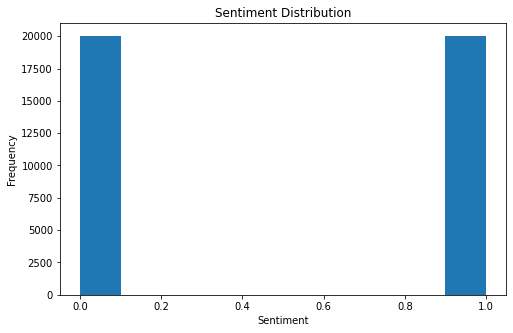

time: 172 ms (started: 2022-12-12 22:40:38 +00:00)


In [ ]:
# Frequency distribution for classes
plt.figure(figsize=(8,5))
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(df['label'])
plt.title('Sentiment Distribution')
plt.show()

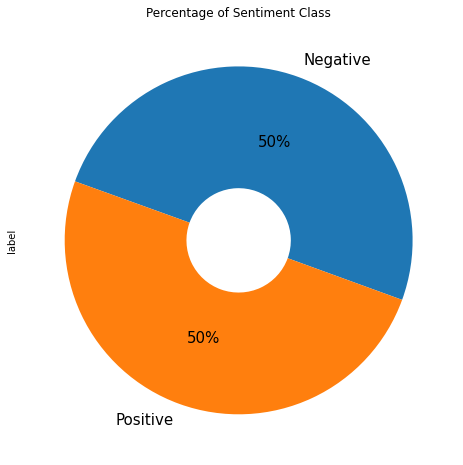

time: 78.8 ms (started: 2022-12-12 22:40:38 +00:00)


In [ ]:
# Pie Chart Distribution
plt.figure(figsize=(8,8))
plt.title('Percentage of Sentiment Class')
df.label.value_counts().plot(kind='pie', labels=['Negative', 'Positive'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.show()

In [ ]:
df.head(1)

,text,label,tokens,no_stop_words,lemm_tokens,WordsCount
0,i grew up b watching and loving the thunderbirds all my mates at school watched we played thund...,0,"[i, grew, up, b, watching, and, loving, the, thunderbirds, all, my, mates, at, school, watched, ...","[grew, b, watching, loving, thunderbirds, mates, school, watched, played, thunderbirds, school, ...","[grew, b, watching, loving, thunderbird, mate, school, watched, played, thunderbird, school, lun...",149


time: 8.31 ms (started: 2022-12-12 22:40:38 +00:00)


In [ ]:
# df['lemm_tokens'][0]

time: 258 µs (started: 2022-12-12 22:40:38 +00:00)


In [ ]:
# Term Frequency Analysis
words = df['lemm_tokens']
allwords = []
for wordlist in words:
  allwords += wordlist

print(allwords[:50])

['grew', 'b', 'watching', 'loving', 'thunderbird', 'mate', 'school', 'watched', 'played', 'thunderbird', 'school', 'lunch', 'school', 'wanted', 'virgil', 'scott', 'one', 'wanted', 'alan', 'counting', 'became', 'art', 'form', 'took', 'child', 'see', 'movie', 'hoping', 'would', 'get', 'glimpse', 'loved', 'child', 'bitterly', 'disappointing', 'high', 'point', 'snappy', 'theme', 'tune', 'could', 'compare', 'original', 'score', 'thunderbird', 'thankfully', 'early', 'saturday', 'morning', 'one']
time: 135 ms (started: 2022-12-12 22:40:38 +00:00)


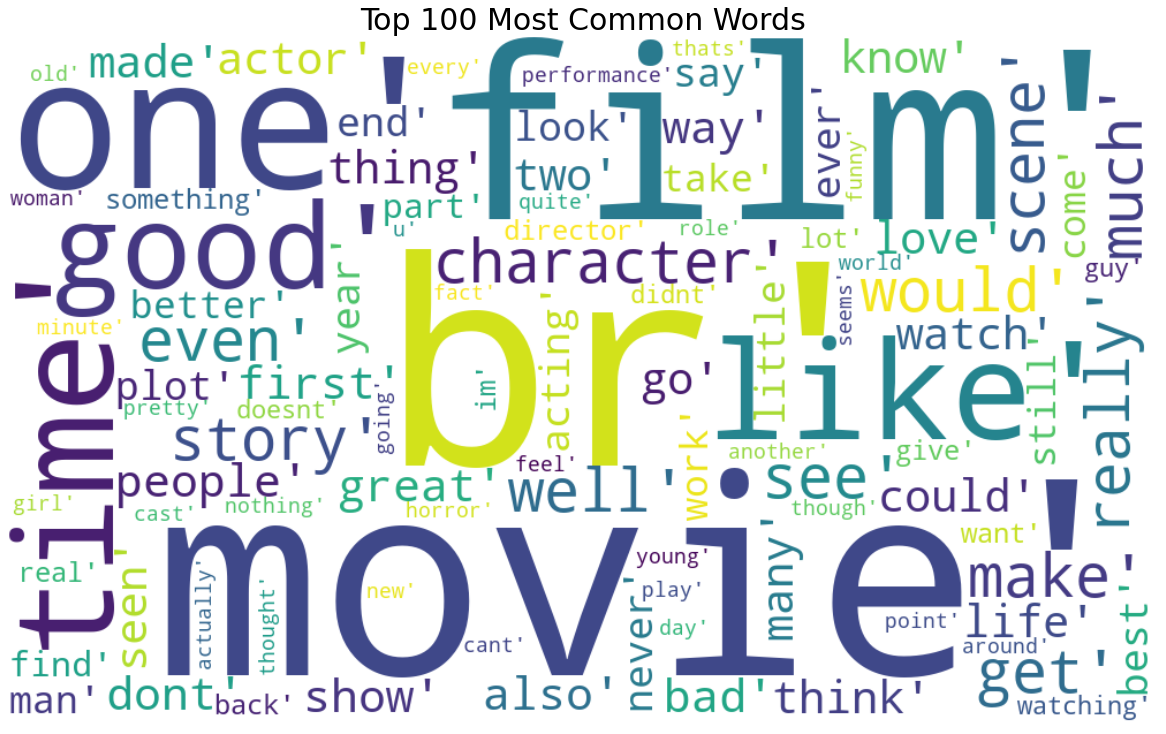

In [ ]:
# Most Common 100 Words
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(20,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

time: 4.52 s (started: 2022-12-12 22:40:38 +00:00)


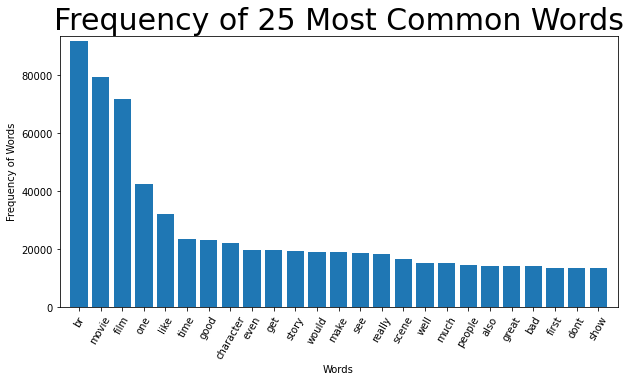

time: 2.78 s (started: 2022-12-12 22:40:43 +00:00)


In [ ]:
# Most Common 25 Words
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,5))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.yticks()
plt.xticks(rotation=60)
plt.title('Frequency of 25 Most Common Words', fontsize=30)
plt.show()

In [ ]:
# Topic Modelling with TF-IDF method
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemm_tokens']]

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaron,abandoned,abc,ability,able,aboutbr,abrupt,absence,absent,absolute,...,youd,youll,young,younger,youre,youth,youve,zero,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.079003,0.0,0.000000,0.0,0.11258,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.167353,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
39996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
39997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.091669,0.0,0.00000,0.0,0.0,0.0
39998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0


time: 5.21 s (started: 2022-12-12 22:40:45 +00:00)


In [ ]:
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

time: 1.04 ms (started: 2022-12-12 22:40:51 +00:00)


In [ ]:
#Non-Negative Matrix Factorization (NMF)
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
like really dont think know people get im didnt thing
Topic 1:
movie watch make made see watching would saw recommend many
Topic 2:
br itbr moviebr filmbr timebr thisbr spoiler allbr onebr rating
Topic 3:
show episode series season tv television funny watch first new
Topic 4:
bad acting plot even good horror effect terrible scene script
Topic 5:
film made director horror many make see cinema scene however
Topic 6:
great good story actor character well performance role best cast
Topic 7:
seen ever one ive worst time best year never dvd
Topic 8:
book read novel story version character series adaptation would original
Topic 9:
life one man woman two scene young story character get
time: 10.7 s (started: 2022-12-12 22:40:51 +00:00)


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
df.head(3)

,text,label,tokens,no_stop_words,lemm_tokens,WordsCount,lemma_str
0,i grew up b watching and loving the thunderbirds all my mates at school watched we played thund...,0,"[i, grew, up, b, watching, and, loving, the, thunderbirds, all, my, mates, at, school, watched, ...","[grew, b, watching, loving, thunderbirds, mates, school, watched, played, thunderbirds, school, ...","[grew, b, watching, loving, thunderbird, mate, school, watched, played, thunderbird, school, lun...",149,grew b watching loving thunderbird mate school watched played thunderbird school lunch school wa...
1,when i put this movie in my dvd player and sat down with a coke and some chips i had some expect...,0,"[when, i, put, this, movie, in, my, dvd, player, and, sat, down, with, a, coke, and, some, chips...","[put, movie, dvd, player, sat, coke, chips, expectations, hoping, movie, would, contain, strongp...","[put, movie, dvd, player, sat, coke, chip, expectation, hoping, movie, would, contain, strongpoi...",326,put movie dvd player sat coke chip expectation hoping movie would contain strongpoints first mov...
2,why do people who do not know what a particular time in the past was like feel the need to try t...,0,"[why, do, people, who, do, not, know, what, a, particular, time, in, the, past, was, like, feel,...","[people, know, particular, time, past, like, feel, need, try, define, time, others, replace, woo...","[people, know, particular, time, past, like, feel, need, try, define, time, others, replace, woo...",183,people know particular time past like feel need try define time others replace woodstock civil w...


time: 20.3 ms (started: 2022-12-12 22:41:01 +00:00)


## *iii) Saving Preprocessed IMDB data*

In [ ]:
# Save final IMDB data
df.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/IMDB_preprocessed.json')

time: 4.91 s (started: 2022-12-12 22:41:32 +00:00)


# 4. Preparing data for Fine-tuning BERT model with IMDB dataset for Predictions on Twitter Dataset (Approach I)

## *i) Import IMDB Dataset for Fine-Training BERT model*

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data Import and loading in Dataframe for Sentiment 140 training
tune_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/IMDB_preprocessed.json')

time: 8.51 s (started: 2022-12-15 00:38:56 +00:00)


In [ ]:
tune_df.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

time: 6.68 ms (started: 2022-12-15 00:39:04 +00:00)


In [ ]:
tune_df.head(1)

,text,label,tokens,no_stop_words,lemm_tokens,WordsCount,lemma_str
0,i grew up b watching and loving the thunderbi...,0,"[i, grew, up, b, watching, and, loving, the, t...","[grew, b, watching, loving, thunderbirds, mate...","[grew, b, watching, loving, thunderbird, mate,...",149,grew b watching loving thunderbird mate school...


time: 12.4 ms (started: 2022-12-15 00:39:04 +00:00)


In [ ]:
tune_df = tune_df[['text', 'label']]
tune_df.head()

,text,label
0,i grew up b watching and loving the thunderbi...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


time: 11.1 ms (started: 2022-12-15 00:39:04 +00:00)


# 6. Fine-Tuned Model Training

## *i) Reading tune_df : Preprocessed Customized IMDB Dataset*

In [ ]:
## Read Sentiment-140 preprocessed dataset for Fine-tuning BERT
tune_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/IMDB_preprocessed.json')
tune_df = tune_df[['text','label']]

tune_df.head(3)

,text,label
0,i grew up b watching and loving the thunderbi...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0


time: 5.26 s (started: 2022-12-15 00:39:04 +00:00)


## *ii) Split train dataset into train, validation and test sets*

In [ ]:
print(tune_df.label.value_counts())

0    20019
1    19981
Name: label, dtype: int64
time: 1.86 ms (started: 2022-12-15 00:39:10 +00:00)


In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(tune_df['text'], tune_df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=tune_df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

time: 32.7 ms (started: 2022-12-15 00:39:10 +00:00)


In [ ]:
len(train_text)

28000

time: 2.72 ms (started: 2022-12-15 00:39:10 +00:00)


## *iii) Define Model Architecture for Fine-tuning (epochs) - Resume RR2 for predictions using saved model*

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Clears output cell post execution
clear_output(wait=False)

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
    
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# number of training epochs
epochs = 5


time: 24 s (started: 2022-12-15 00:39:10 +00:00)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## *iv) Tokenization*

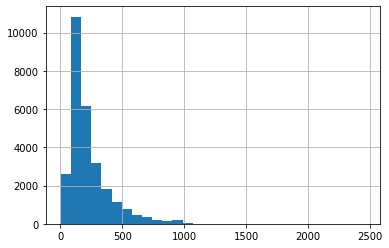

time: 565 ms (started: 2022-12-15 00:39:34 +00:00)


In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max(seq_len)

2460

time: 3.25 ms (started: 2022-12-15 00:39:34 +00:00)


In [ ]:
max_seq_len = 50

time: 406 µs (started: 2022-12-15 00:39:34 +00:00)


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


time: 6.18 s (started: 2022-12-15 00:39:34 +00:00)


## *v) Convert Sequences to Tensors*

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

time: 240 ms (started: 2022-12-15 00:39:40 +00:00)


## *vi) Create DataLoaders*

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
# batch_size = 32
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

time: 1.37 ms (started: 2022-12-15 00:39:41 +00:00)


## *vii) Find Class Weights, define Loss*

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight ='balanced', \
                                 classes= np.unique(train_labels), \
                                 y=train_labels)

print(class_wts)

[0.99907229 1.00092943]
time: 6.39 ms (started: 2022-12-15 00:39:41 +00:00)


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

time: 1.37 ms (started: 2022-12-15 00:39:41 +00:00)


## *viii) Fine-Tune BERT Trainer definition*

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

  # function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
              
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

time: 3 ms (started: 2022-12-15 00:39:41 +00:00)


## *ix) Initiate Training*

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_bert_IMDB_ep10_GPU.pt')
        
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_bert_IMDB_ep5_GPU.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    875.
  Batch   100  of    875.
  Batch   150  of    875.
  Batch   200  of    875.
  Batch   250  of    875.
  Batch   300  of    875.
  Batch   350  of    875.
  Batch   400  of    875.
  Batch   450  of    875.
  Batch   500  of    875.
  Batch   550  of    875.
  Batch   600  of    875.
  Batch   650  of    875.
  Batch   700  of    875.
  Batch   750  of    875.
  Batch   800  of    875.
  Batch   850  of    875.

Evaluating...
  Batch    50  of    188.
  Batch   100  of    188.
  Batch   150  of    188.

Training Loss: 0.639
Validation Loss: 0.580

 Epoch 2 / 5
  Batch    50  of    875.
  Batch   100  of    875.
  Batch   150  of    875.
  Batch   200  of    875.
  Batch   250  of    875.
  Batch   300  of    875.
  Batch   350  of    875.
  Batch   400  of    875.
  Batch   450  of    875.
  Batch   500  of    875.
  Batch   550  of    875.
  Batch   600  of    875.
  Batch   650  of    875.
  Batch   700  of    875.
  Batch   750  of    875.
  

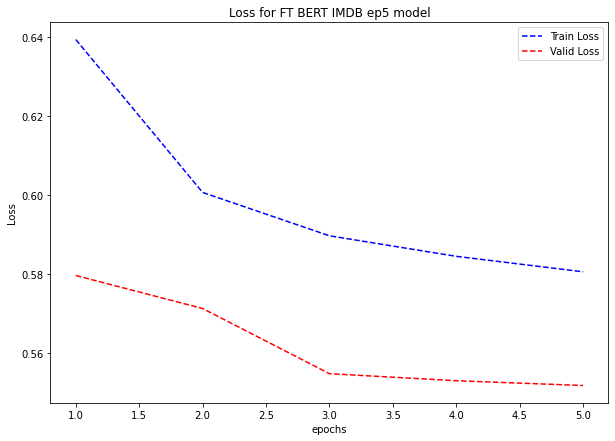

time: 167 ms (started: 2022-12-15 00:48:08 +00:00)


In [ ]:
#Plotting Model Loss
import matplotlib.pyplot as plt

# x is no of epochs
x = np.arange(epochs)+1

plt.figure(figsize = (10,7))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('Loss for FT BERT IMDB ep5 model')
plt.plot(x, train_losses, 'b--', label = 'Train Loss')
plt.plot(x, valid_losses, 'r--', label = 'Valid Loss')
plt.legend()

plt.show()

# Change names for model-wise outputs
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Loss for FT BERT IMDB ep10 model.png')

# plt.savefig('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Loss for FT BERT IMDB ep5 model.png')

## *x) Load Saved Model and Plot Loss*

In [ ]:
#load weights of best model with ep5/ ep10
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_bert_IMDB_ep5_GPU.pt'

path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_bert_IMDB_ep10_GPU.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

time: 528 ms (started: 2022-12-14 21:31:49 +00:00)


# 7. Predictions on IMDB Test Dataset

In [ ]:
torch.cuda.empty_cache()

#load weights of best model
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/IMDB_exp2/saved_weights_IMDB_FT_BERT_ep10_GPU.pt'
# model.load_state_dict(torch.load(path))

time: 2.46 ms (started: 2022-12-14 21:31:52 +00:00)


In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  # preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

time: 7.38 s (started: 2022-12-14 21:41:41 +00:00)


In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print('Scores_FT_BERT_IMDB_ep10_test\n')
print(classification_report(test_y, preds))


Scores_FT_BERT_IMDB_ep5_test

              precision    recall  f1-score   support

           0       0.89      0.54      0.67      7000
           1       0.67      0.94      0.78      7000

    accuracy                           0.74     14000
   macro avg       0.78      0.74      0.73     14000
weighted avg       0.78      0.74      0.73     14000

time: 20.4 ms (started: 2022-12-14 21:41:49 +00:00)


In [ ]:
# confusion matrix
cfm =pd.crosstab(test_y, preds)
cfm.astype('int32')

col_0,0,1
row_0,,
0,3771,3229
1,452,6548


time: 16.1 ms (started: 2022-12-14 21:41:49 +00:00)


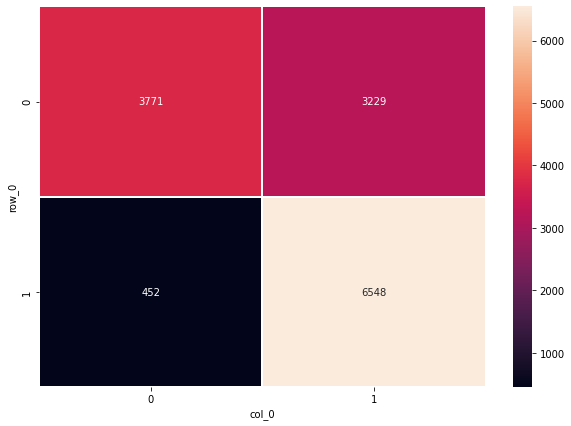

time: 171 ms (started: 2022-12-14 21:43:02 +00:00)


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cfm = pd.DataFrame(cfm)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot =True, linewidths =1, fmt='g')

# # Save confusion matrix
# cfm_plot.figure.savefig\
# ('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/CFM_FT_BERT_IMDB_ep5_twitter.png')

In [ ]:
pd.DataFrame(preds).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_FT_BERT_IMDB_ep5_test.csv')


time: 16.6 ms (started: 2022-12-13 15:30:40 +00:00)


# 8. Testing on Twitter Dataset for Performance of Fine-Tuned BERT


In [ ]:
torch.cuda.empty_cache()

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.metrics import roc_curve, auc

#load weights of best model
# path = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_FT_bert_IMDB_ep10_GPU.pt'
# model.load_state_dict(torch.load(path))

# load Twitter Dataset for Testing performance
path = r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Benchmark_Twitter/Benchmark_Twitter_Labels.json'
twitter_df = pd.read_json(path)
twitter_df = twitter_df[['text','roberta_sent']]
twitter_df.rename(columns ={'roberta_sent': 'label'}, inplace=True)

twitter_df.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,text,label
0,utterly shocked and saddened by this youth ico...,0
1,this murder case should be handover to cbi enq...,0
2,pamicus curiae if life is cycled in this state...,0
3,last year in august sad youth leader vikramjit...,0
4,i am shocked at murder of siddhu moosawala hea...,0


time: 1.62 s (started: 2022-12-14 21:44:02 +00:00)


In [ ]:
twitter_df.isna().any()

text     False
label    False
dtype: bool

time: 19 ms (started: 2022-12-14 21:44:08 +00:00)


In [ ]:
twitter_df.label.value_counts()

0    137984
1     25642
Name: label, dtype: int64

time: 5.89 ms (started: 2022-12-14 21:44:08 +00:00)


In [ ]:
# Downsizing data for testing due to CUDA memory limitation

# Negative Labels count
twitter_df_0 = twitter_df[twitter_df['label'] == 0]
print(twitter_df_0.label.value_counts())
# Positive Labels count
twitter_df_1 = twitter_df[twitter_df['label'] == 1]
print(twitter_df_1.label.value_counts())

0    137984
Name: label, dtype: int64
1    25642
Name: label, dtype: int64
time: 16.6 ms (started: 2022-12-14 21:44:10 +00:00)


In [ ]:
twitter_df = pd.concat([twitter_df_0[:7000],twitter_df_1[:7000]])
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 0 to 43235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14000 non-null  object
 1   label   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 328.1+ KB
time: 10.3 ms (started: 2022-12-14 21:44:12 +00:00)


In [ ]:
# Fix twitter_text , twitter_y for model predictions
twitter_text = twitter_df['text']
twitter_labels = twitter_df['label']

time: 516 µs (started: 2022-12-14 21:44:13 +00:00)


In [ ]:
# Change test_text, test_y, test_mask
max_seq_len = 50

tokens_twitter_test = tokenizer.batch_encode_plus(
    twitter_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for twitter test set
test_seq = torch.tensor(tokens_twitter_test['input_ids'])
test_mask = torch.tensor(tokens_twitter_test['attention_mask'])
test_y = torch.tensor(twitter_labels.tolist())

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


time: 405 ms (started: 2022-12-14 21:44:14 +00:00)


In [ ]:
torch.cuda.empty_cache()

# get predictions for twitter data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  # preds_twitter = model(test_seq, test_mask)

  preds_twitter = preds.detach().cpu().numpy()

time: 7.41 s (started: 2022-12-14 21:44:16 +00:00)


In [ ]:
# model's performance on Twitter Dataset 
preds_twitter = np.argmax(preds_twitter, axis = 1)
print(classification_report(test_y, preds_twitter))

# confusion matrix
print(pd.crosstab(test_y, preds_twitter))

# Saving predictions for Metrics Scores
pd.DataFrame(preds_twitter).to_csv(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Embeddings_and_Preds/Preds_FT_BERT_IMDB_ep10_for_Twitter.csv')


              precision    recall  f1-score   support

           0       0.89      0.54      0.67      7000
           1       0.67      0.94      0.78      7000

    accuracy                           0.74     14000
   macro avg       0.78      0.74      0.73     14000
weighted avg       0.78      0.74      0.73     14000

col_0     0     1
row_0            
0      3771  3229
1       452  6548
time: 55.5 ms (started: 2022-12-14 21:44:25 +00:00)


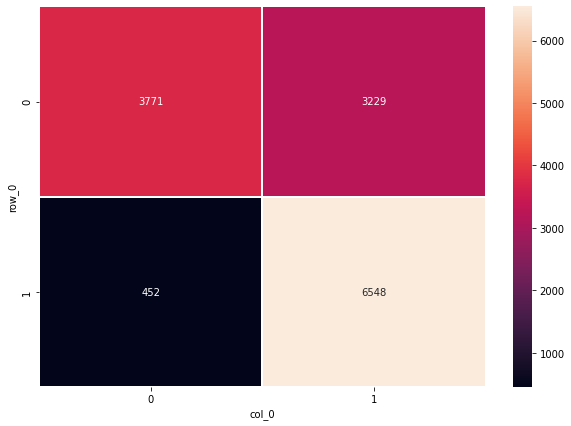

time: 186 ms (started: 2022-12-14 21:44:31 +00:00)


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

# confusion matrix
cfm =pd.crosstab(test_y, preds_twitter)
cfm.astype('int32')

df_cfm = pd.DataFrame(cfm)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot =True, linewidths =1, fmt='g')

# # Save confusion matrix
# cfm_plot.figure.savefig\
# ('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/CFM_FT_BERT_IMDB_ep5_twitter.png')

In [ ]:
twitter_df['label2'] = preds_twitter
twitter_df.head()

,text,label,label2
0,utterly shocked and saddened by this youth ico...,0,1
1,this murder case should be handover to cbi enq...,0,0
2,pamicus curiae if life is cycled in this state...,0,1
3,last year in august sad youth leader vikramjit...,0,0
4,i am shocked at murder of siddhu moosawala hea...,0,1


time: 7.07 ms (started: 2022-12-13 15:32:29 +00:00)


In [ ]:
## Save final Twitter Data with labels from approach 1
twitter_df.reset_index(inplace=True, drop='index')
twitter_df.to_json('/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_IMDB_ep5.json')
# twitter_df.drop('FT_Sent', axis=1, inplace =True)
twitter_df.tail(10)

,text,label,label2
13990,very good team jhunjhunuwe trust in our new yo...,1,1
13991,lets tackle crime by making investments in spo...,1,1
13992,did you know early childhood intervention is a...,1,1
13993,well see you at the charles young park today a...,1,1
13994,just finished about a hard line judge sentenci...,1,1
13995,saturday bringing people together to pray and ...,1,1
13996,inorder to save youth from falling prey to dru...,1,1
13997,great to see the team down at sharing informat...,1,1
13998,reflecting on forgiveness and the need to stan...,1,1
13999,the groom in the front is likely going to be a...,1,1


time: 33.5 ms (started: 2022-12-13 15:32:29 +00:00)


# 9. Results on Twitter 14k Dataset Using Fine-tuned BERT model (Approach I)

In [ ]:
# twitter_df.reset_index(inplace=True, drop='index')
# twitter_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_IMDB_ep5.json')
twitter_df.head(10)

,text,label,label2
0,utterly shocked and saddened by this youth ico...,0,1
1,this murder case should be handover to cbi enq...,0,0
2,pamicus curiae if life is cycled in this state...,0,1
3,last year in august sad youth leader vikramjit...,0,0
4,i am shocked at murder of siddhu moosawala hea...,0,1
5,teenagerit is legal for a year old to walk in...,0,1
6,even if that were the case wed still have a sy...,0,1
7,man if you own a gun shop and you are confront...,0,0
8,unlike most spheres of drugs youth overdose is...,0,1
9,whole generations of maldivian youth r lost in...,0,0


time: 6.38 ms (started: 2022-12-13 15:32:35 +00:00)


In [ ]:
twitter_df.label.value_counts()

0    7000
1    7000
Name: label, dtype: int64

time: 3.98 ms (started: 2022-12-13 15:32:36 +00:00)


In [ ]:
twitter_df.label2.value_counts()

1    10671
0     3329
Name: label2, dtype: int64

time: 3.63 ms (started: 2022-12-13 15:32:36 +00:00)


# 10. BERT Embeddings extracted for Support Vector Classification (Approach II)

Model Training using BERT embeddings for Twitter 14k dataset using SVC Classifier

### Import Twitter 14k Dataset

In [ ]:
# Empty CUDA memory 
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Twitter 14k dataset
twitter_df = pd.read_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_FT_BERT_IMDB_ep5.json')
twitter_df.head()

,text,label,label2
0,utterly shocked and saddened by this youth icons murder,0,0
1,this murder case should be handover to cbi enquirybecause state government order to pull back se...,0,0
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder...,0,1
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mo...,0,0
4,i am shocked at murder of siddhu moosawala heard him sing in melbourne years back and then he ve...,0,1


time: 95.4 ms (started: 2022-12-12 23:31:23 +00:00)


In [ ]:
twitter_df.shape

(14000, 3)

time: 2.65 ms (started: 2022-12-12 23:31:55 +00:00)


### Feature Engineering Using BERT model embeddings

In [ ]:
# Approach 2 FEATURE EXTRACTION METHOD WITH ML MODEL

from transformers import BertModel, BertTokenizer, BertTokenizerFast 
import torch

model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_name)

print('Module %s loaded for feature engineering!!! ' % model_name,'\n')

data = twitter_df['text']
# data = data.to_list()

batch_size =32

X = np.empty((batch_size, 768), int)

for idx in range(0, len(data), batch_size):
  batch = data[idx:min(len(data),idx+batch_size)]
  encoded_tokens = tokenizer.batch_encode_plus(batch, max_length = 20, padding = 'max_length', truncation =True)
  encoded = {key: torch.LongTensor(value) for key,value in encoded_tokens.items()}

  with torch.no_grad():
    outputs = model(**encoded)
    X = np.append(X, outputs['pooler_output'], axis=0)

# Features extracted from BERT model
training_features = X[batch_size:,:]
# print(training_features)
clear_output(wait=False)

time: 2min 17s (started: 2022-12-12 23:32:49 +00:00)


### Model Training and Scores

In [ ]:
# Implementing ML algos on BERT embeddings as features and train_labels as target values
from sklearn.svm import SVC 
mdl = SVC(probability=True,random_state = 100)

time: 694 µs (started: 2022-12-12 23:35:07 +00:00)


In [ ]:
Xtrain, Xtemp, ytrain, ytemp = train_test_split(training_features, twitter_df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=twitter_df['label'])

# we will use temp sets to create validation and test set
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, random_state=2018, test_size=0.5,stratify=ytemp)

time: 45.8 ms (started: 2022-12-12 23:35:27 +00:00)


In [ ]:
# Model training
mdl.fit(Xtrain,ytrain)

SVC(probability=True, random_state=100)

time: 2min 22s (started: 2022-12-12 23:35:29 +00:00)


In [ ]:
# Classification Scores on Validation set
preds = mdl.predict(Xval)
print(classification_report(yval, preds))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1050
           1       0.83      0.80      0.82      1050

    accuracy                           0.82      2100
   macro avg       0.82      0.82      0.82      2100
weighted avg       0.82      0.82      0.82      2100

time: 6.21 s (started: 2022-12-12 23:37:52 +00:00)


In [ ]:
# Classification Scores on Test set
preds_test = mdl.predict(Xtest)
print(classification_report(ytest, preds_test))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1050
           1       0.84      0.82      0.83      1050

    accuracy                           0.83      2100
   macro avg       0.83      0.83      0.83      2100
weighted avg       0.83      0.83      0.83      2100

time: 6.29 s (started: 2022-12-12 23:37:58 +00:00)


In [ ]:
import pickle
# save the model
filename = '/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Saved_Models/Model_SVC_bert_Twitter14k.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model 
# loaded_model = pickle.load(open(filename, 'rb'))

# result = loaded_model.score(X_test, Y_test)


time: 879 ms (started: 2022-12-12 23:38:04 +00:00)


AUC for our classifier is: 0.9065773242630386


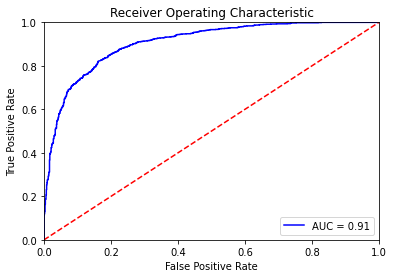

time: 7.14 s (started: 2022-12-12 23:38:05 +00:00)


In [ ]:
# Metrics for RF 
# Importing all necessary libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class_probabilities = mdl.predict_proba(Xtest)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Adding SVC_bert_labels as label3
preds = mdl.predict(training_features)
twitter_df['label3'] = preds
twitter_df.head()

,text,label,label2,label3
0,utterly shocked and saddened by this youth icons murder,0,0,0
1,this murder case should be handover to cbi enquirybecause state government order to pull back se...,0,0,0
2,pamicus curiae if life is cycled in this state then it has the hellions fate to thrive in murder...,0,1,0
3,last year in august sad youth leader vikramjit singh alias vicky middhukhera was shot dead at mo...,0,0,1
4,i am shocked at murder of siddhu moosawala heard him sing in melbourne years back and then he ve...,0,1,0


time: 44.1 s (started: 2022-12-12 23:39:07 +00:00)


In [ ]:
twitter_df.shape

(14000, 4)

time: 2.45 ms (started: 2022-12-12 23:39:51 +00:00)


In [ ]:
twitter_df.to_json(r'/content/drive/MyDrive/Colab Notebooks/Final_Thesis_Code_Artifacts/Results/Twitter14k_SVC_bert.json')

time: 25 ms (started: 2022-12-12 23:40:31 +00:00)
